## Importing statements

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import random

from sklearn.linear_model import Lasso, LinearRegression as LR
from sklearn.linear_model import Ridge

from sklearn.gaussian_process import GaussianProcessRegressor as gpr
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

from sklearn.preprocessing import PolynomialFeatures as PF
from sklearn.preprocessing import StandardScaler as SS

from sklearn.model_selection import train_test_split as tts

from IPython.display import clear_output
from datetime import datetime as dt

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

from scipy import stats
from scipy.stats import ks_2samp
from scipy.stats import kstest

from scipy.stats import wasserstein_distance


## Testing Lasso/GPR/RFR on real math functions

Adding noise as well to see how it affects the fit

In [3]:
def f(x):
  return np.exp(-abs(x)**2)

In [4]:
f(-1)

0.36787944117144233

In [5]:
X = np.linspace(start=-10, stop=10, num=1_000).reshape(-1, 1)
y = np.squeeze(f(X))

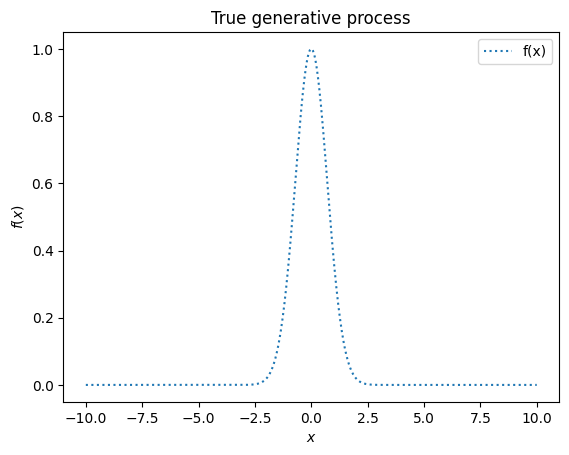

In [6]:
import matplotlib.pyplot as plt

plt.plot(X, y, label=r"f(x)", linestyle="dotted")
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
_ = plt.title("True generative process")

In [7]:
rng = np.random.RandomState(1)
training_indices = rng.choice(np.arange(y.size), size=50, replace=False)
X_train, y_train = X[training_indices], y[training_indices]

In [8]:
constant = 0.251**2

kernel = constant * RBF(length_scale=0.917, length_scale_bounds=(1e-2, 1e2)) # The RBF kernel with a large length-scale enforces this component to be smooth

model = gpr(kernel=kernel, n_restarts_optimizer=9) # no clue what this is
model.fit(X_train, y_train)
model.kernel_

0.225**2 * RBF(length_scale=0.978)

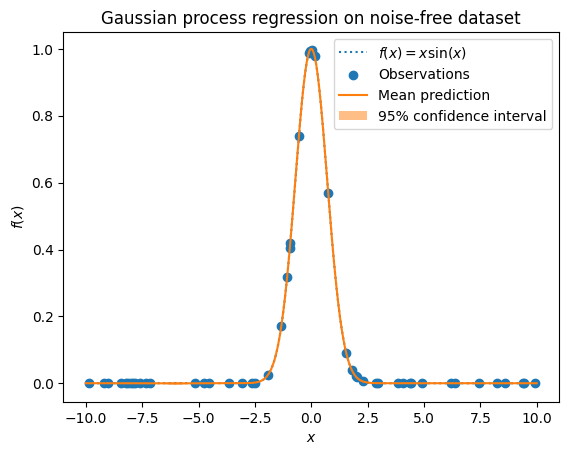

In [9]:
mean_prediction, std_prediction = model.predict(X, return_std=True)

plt.plot(X, y, label=r"$f(x) = x \sin(x)$", linestyle="dotted")
plt.scatter(X_train, y_train, label="Observations")
plt.plot(X, mean_prediction, label="Mean prediction")
plt.fill_between(
    X.ravel(),
    mean_prediction - 1.96 * std_prediction,
    mean_prediction + 1.96 * std_prediction,
    alpha=0.5,
    label=r"95% confidence interval",
)
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
_ = plt.title("Gaussian process regression on noise-free dataset")

In [10]:
noise_std = 0.1 # parameter
y_train_noisy = y_train + rng.normal(loc=0.0, scale=noise_std, size=y_train.shape)

In [11]:
gaussian_process = gpr(
    kernel=kernel, alpha= noise_std**2, n_restarts_optimizer=10
) # not sure what alpha is
gaussian_process.fit(X_train, y_train_noisy)
mean_prediction, std_prediction = gaussian_process.predict(X, return_std=True)

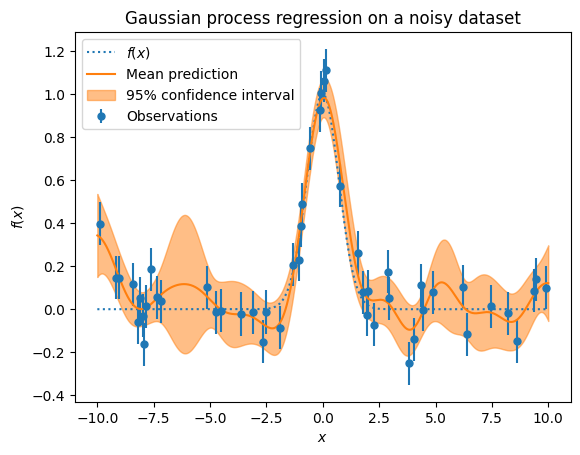

In [12]:
plt.plot(X, y, label=r"$f(x)$", linestyle="dotted")
plt.errorbar(
    X_train,
    y_train_noisy,
    noise_std,
    linestyle="None",
    color="tab:blue",
    marker=".",
    markersize=10,
    label="Observations",
)
plt.plot(X, mean_prediction, label="Mean prediction")
plt.fill_between(
    X.ravel(),
    mean_prediction - 1.96 * std_prediction,
    mean_prediction + 1.96 * std_prediction,
    color="tab:orange",
    alpha=0.5,
    label=r"95% confidence interval",
)
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
_ = plt.title("Gaussian process regression on a noisy dataset")

## creating functions

In [31]:
from scipy.stats.qmc import LatinHypercube

import numpy as np
import matplotlib.pyplot as plt

In [32]:
import itertools

def expand_grid(data_dict):
    """Create a dataframe from every combination of given values."""
    rows = itertools.product(*data_dict.values())
    return pd.DataFrame.from_records(rows, columns=data_dict.keys())

In [33]:
from matplotlib.cm import datad
import pandas as pd

def create_data(n_dimensions, n_rows):
  """
  Regardless of dimension, splitting the array into lists
  """
  d = {}

  for x_dim in range(1, n_dimensions+1):
      d["x_{0}".format(x_dim)] = []

  keys = list(d.keys())

  for key in keys:
    d[key] = []
    d[key]  +=  list(np.linspace(start= -3, stop= 3, num= n_rows))


  plot_df = expand_grid(d)

  plot_df = pd.DataFrame(plot_df)

  df = pd.DataFrame(d)

  return plot_df, d

In [34]:
plot_df, d = create_data(2, 20)

In [35]:
plot_df

,x_1,x_2
0,-3.0,-3.000000
1,-3.0,-2.684211
2,-3.0,-2.368421
3,-3.0,-2.052632
4,-3.0,-1.736842
...,...,...
395,3.0,1.736842
396,3.0,2.052632
397,3.0,2.368421
398,3.0,2.684211


In [36]:
def square(a):

  new_list = []

  for i in a:
    i = i**2
    new_list.append(i)

  return(new_list)


In [37]:

def gaussian_bump(dataframe):

  df = dataframe.copy()

  y_column = []

  for row in range(len(df)):

    x_values = list(df.loc[row])

    y_value = np.exp(-np.sqrt(sum(square(x_values)))**2)

    y_column.append(y_value)

  df['f(x)'] = y_column

  return df

import numpy as np

def power(a, n):

  new_list = []

  for i in a:
    i = i**n
    new_list.append(i)

  return(new_list)



def styblinski_tang(dataframe):

  df = dataframe.copy()

  y_column = []

  for row in range(len(df)):

    x_values = list(df.loc[row])

    y_value = sum(power(x_values, 4))-16*sum(power(x_values,2))+5*sum(x_values)

    y_column.append(y_value)

  df['f(x)'] = y_column

  return df


In [38]:
def add_zeros(df, starting_index, n):

  df_copy = df.copy()

  d = {}

  for zero_col in range(starting_index, starting_index+n):
      d["x_{0}".format(zero_col)] = [0]*len(df_copy)

  zeros_df = pd.DataFrame(d)

  print(zeros_df.head())

  new_df = pd.concat([df_copy, zeros_df], axis=1, join='inner')

  return new_df

In [39]:
def dimension_test(n_dimensions, n_rows):  # not working


  df, d = create_data(n_dimensions, n_rows)

 #df = gaussian_bump(df)
  df = styblinski_tang(df)

  print(df.head())

  X = df.drop('f(x)',axis=1)
  y = df['f(x)']

  var1_seq = np.linspace(start= -5, stop= 5, num= n_rows**2)
  var2_seq = np.linspace(start= -5, stop= 5, num= n_rows**2)

  plot_df = expand_grid({'x_1': var1_seq, 'x_2': var2_seq}) # need to make it a new name

  #plot_df = gaussian_bump(plot_df)
  plot_df = styblinski_tang(plot_df)

  x1_grid = plot_df['x_1'].to_numpy().reshape((len(var1_seq),len(var2_seq)))
  x2_grid = plot_df['x_2'].to_numpy().reshape((len(var1_seq),len(var2_seq)))
  f_grid = plot_df['f(x)'].to_numpy().reshape((len(var1_seq),len(var2_seq)))

  plt.pcolormesh(x1_grid,x2_grid,f_grid)
  plt.title('Truth')
  plt.show()

  # ---

  constant = 1
  kernel = constant * RBF(length_scale= 1.0, length_scale_bounds=(1e-2, 1e2))
  model = gpr(kernel=kernel, n_restarts_optimizer=9)

  # ---

  MAE = []

  for i in range(1,n_dimensions+1):

    n_constants = len(X.columns) - i

    new_df, d = create_data(i, n_rows)

    #new_df = gaussian_bump(new_df)
    new_df = styblinski_tang(new_df)

    print(new_df.head())

    new_X = new_df.drop('f(x)',axis=1)

    print("n_constants =" +str(n_constants))

    print(new_X.head())

    new_y = new_df['f(x)']

    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(new_X, new_y, test_size=0.2, random_state=42)

    model.fit(X_train, y_train)

    y_test_pred = model.predict(X.iloc[:,0:i])

    MAE_obs = mean_absolute_error(y, y_test_pred)
    MAE.append(MAE_obs)

    print(str(MAE_obs))

  return df, MAE, n_dimensions, n_rows


## how the number of rows impacts performance

In [ ]:
df, MAE7, n_dimensions, n_rows = dimension_test(3, 7)
df, MAE8, n_dimensions, n_rows = dimension_test(3, 8)
df, MAE9, n_dimensions, n_rows = dimension_test(3, 9)
df, MAE10, n_dimensions, n_rows = dimension_test(3, 10)

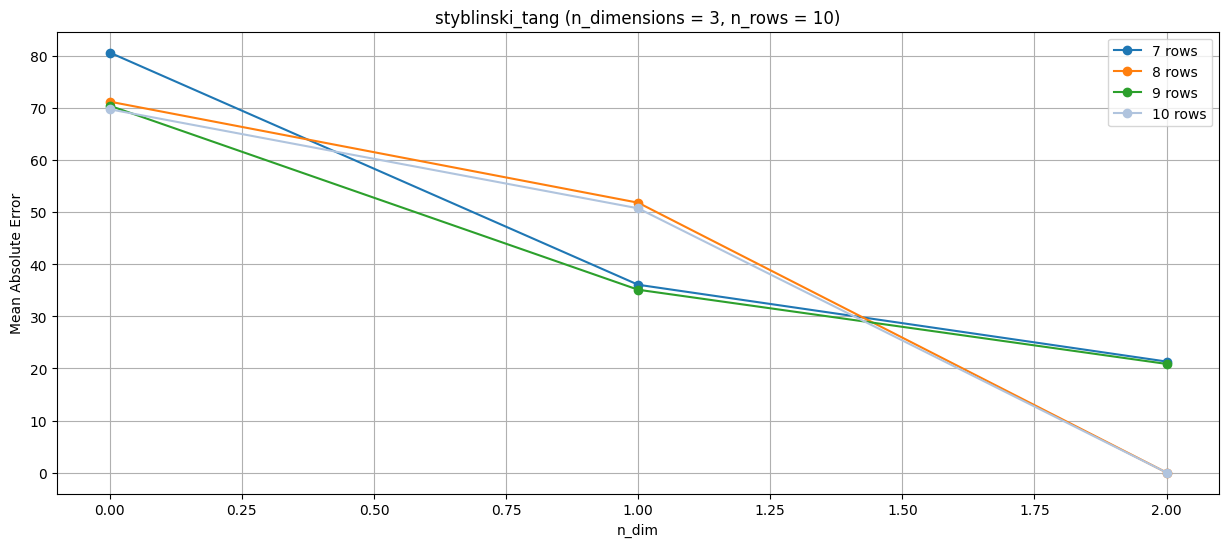

In [24]:
n_var = range(n_dimensions)

plt.figure(figsize=(15,6))

plt.plot(n_var, MAE7, 'o-', label='7 rows')
plt.plot(n_var, MAE8, 'o-', label='8 rows')
plt.plot(n_var, MAE9, 'o-', label='9 rows')
plt.plot(n_var, MAE10, 'o-', color='lightsteelblue', label='10 rows')

plt.legend()
plt.grid()
plt.xlabel('n_dim')
plt.ylabel('Mean Absolute Error')
plt.title('styblinski_tang (n_dimensions = '+str(n_dimensions)+', n_rows = '+str(n_rows)+')')
plt.show()

## rows_test

In [25]:
def rows_test(n_dimensions, min_n_row, max_n_row, n_comparison_row):


  new_x_test , d = create_data(n_dimensions, n_comparison_row)

  #test_df = gaussian_bump(new_x_test)
  test_df = styblinski_tang(new_x_test)


  new_y_test = test_df['f(x)']


  # --- Heatmapping

  var1_seq = np.linspace(start= -3, stop= 3, num= n_comparison_row)
  var2_seq = np.linspace(start= -3, stop= 3, num= n_comparison_row)

  plot_df = expand_grid({'x_1': var1_seq, 'x_2': var2_seq})

  #plot_df = gaussian_bump(plot_df)
  plot_df = styblinski_tang(plot_df)

  x1_grid = plot_df['x_1'].to_numpy().reshape((len(var1_seq),len(var2_seq)))
  x2_grid = plot_df['x_2'].to_numpy().reshape((len(var1_seq),len(var2_seq)))
  f_grid = plot_df['f(x)'].to_numpy().reshape((len(var1_seq),len(var2_seq)))


  plt.pcolormesh(x1_grid,x2_grid,f_grid)
  plt.title('Truth')
  plt.show()

  # --- Make a dataset for each n_rows

  MAE = []
  new_MAE = []

  for n_rows in range(min_n_row, max_n_row+1):

    print("n_row = "+str(n_rows))

    df, d = create_data(n_dimensions, n_rows)

    #df = gaussian_bump(df)
    df = styblinski_tang(df)

    X = df.drop('f(x)',axis=1)

    y = df['f(x)']

  # ---

    constant = 1
    kernel = constant * RBF(length_scale= 1.0, length_scale_bounds=(1e-2, 1e2))
    model = gpr(kernel=kernel, n_restarts_optimizer=9)

  # ---

    print("TTS'ing")

    from sklearn.model_selection import train_test_split

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    print("Fitting model")

    model.fit(X_train, y_train)

    y_test_pred = model.predict(X_test)
    MAE_obs = mean_absolute_error(y_test, y_test_pred)
    MAE.append(MAE_obs)

    new_test_pred = model.predict(new_x_test)
    new_MAE_obs = mean_absolute_error(new_y_test, new_test_pred)
    new_MAE.append(new_MAE_obs)

    print(str(MAE_obs))
    print(str(new_MAE_obs))

    var1_seq = np.linspace(start= -3, stop= 3, num= n_comparison_row)
    var2_seq = np.linspace(start= -3, stop= 3, num= n_comparison_row)

    plot_df = expand_grid({'x_1': var1_seq, 'x_2': var2_seq})

    plot_df = add_zeros(plot_df, 3, n_dimensions - 2)

    plot_df['f(x)'] = list(model.predict(plot_df))

    x1_grid = plot_df['x_1'].to_numpy().reshape((len(var1_seq),len(var2_seq)))
    x2_grid = plot_df['x_2'].to_numpy().reshape((len(var1_seq),len(var2_seq)))
    f_grid = plot_df['f(x)'].to_numpy().reshape((len(var1_seq),len(var2_seq)))

    plt.pcolormesh(x1_grid, x2_grid, f_grid)
    plt.title('n_rows = '+str(n_rows))
    plt.show()

  return MAE, new_MAE, n_dimensions, min_n_row, max_n_row, n_comparison_row


## running rows_test

In [ ]:
MAE, new_MAE, n_dimensions, min_n_row, max_n_row, n_comparison_row = rows_test(3, 2, 10, 25)

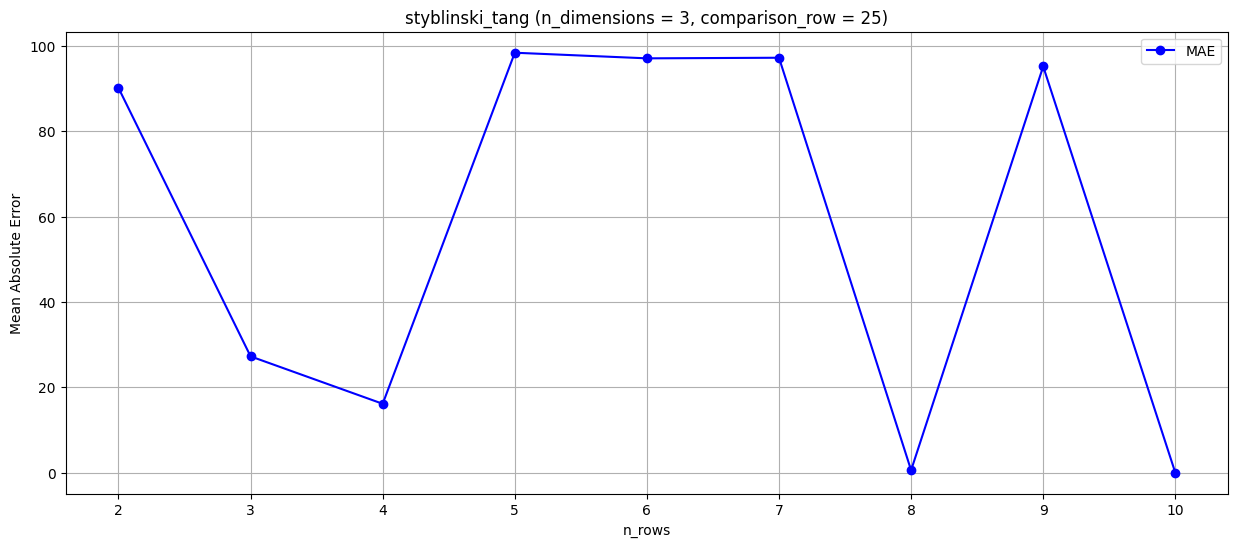

In [29]:
n_rows = range(min_n_row, max_n_row+1)

plt.figure(figsize=(15,6))

plt.plot(n_rows, new_MAE, 'o-', color='blue', label='MAE')

plt.legend()
plt.grid()
plt.xlabel('n_rows')
plt.ylabel('Mean Absolute Error')
plt.title('styblinski_tang (n_dimensions = '+str(n_dimensions)+', comparison_row = '+str(n_comparison_row)+')')
plt.show()